In [93]:
import numpy as np 
import pandas as pd 
import os
import numpy as np
import gensim
import matplotlib.pyplot as plt
import seaborn as sns
import gensim.downloader as api
import seaborn as sns
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/data-assignment/ds-assignment/user-interactions.csv
/kaggle/input/data-assignment/ds-assignment/metadata.csv


In [94]:
%matplotlib inline

#### Due to limited amount of memory capacity we are only using selecting 1 million interaction dataset

In [95]:
indata= pd.read_csv("/kaggle/input/data-assignment/ds-assignment/user-interactions.csv",nrows=1000000)

In [96]:
metadata = pd.read_csv("/kaggle/input/data-assignment/ds-assignment/metadata.csv")

In [97]:
indata.head()

,user_id,pratilipi_id,read_percent,updated_at
0,5506791963854965,1377786220672965,100.0,2022-03-23 00:08:26.227
1,5506791979071996,1377786219742624,29.0,2022-03-23 00:08:26.220
2,5506791980256358,1377786217096334,22.0,2022-03-23 00:08:26.020
3,5506791988747277,1377786224767880,100.0,2022-03-23 00:08:25.306
4,5506791992372558,1377786218111595,100.0,2022-03-23 00:08:25.250


In [98]:
metadata.head()

,author_id,pratilipi_id,category_name,reading_time,updated_at,published_at
0,-3418949279741297,1025741862639304,translation,0,2020-08-19 15:26:13,2016-09-30 10:37:04
1,-2270332351871840,1377786215601277,translation,171,2021-01-21 16:27:07,2018-06-11 13:17:48
2,-2270332352037261,1377786215601962,translation,92,2020-09-29 12:33:57,2018-06-12 04:19:12
3,-2270332352521845,1377786215640994,translation,0,2019-10-17 09:03:37,2019-09-26 14:58:53
4,-2270332349665658,1377786215931338,translation,47,2020-05-05 11:33:41,2018-11-25 12:28:23


In [99]:
metadata.shape,indata.shape

((954501, 6), (1000000, 4))

In [100]:
metadata.columns,indata.columns

(Index(['author_id', 'pratilipi_id', 'category_name', 'reading_time',
        'updated_at', 'published_at'],
       dtype='object'),
 Index(['user_id', 'pratilipi_id', 'read_percent', 'updated_at'], dtype='object'))

## Visualization and Understanding Distributions across DataSet

In [101]:
# Frequency across categories
metadata["category_name"].value_counts()

romance                      193220
shortstories                 102097
social                        73920
suspense                      64041
family                        58515
novels                        53584
life                          51356
moral-inspiring               47421
women                         37168
horror                        28506
entertainment                 23362
action-and-adventure          21589
experiences-and-memories      20276
webseries                     16227
relegion-and-spiritual        15476
comedy                        14893
Pratilipi-kalamkar-samman     13237
mythology                     12324
children                      10196
Indiawale                      9674
Pratilipi-Awards-Hindi         9342
fantasy                        9324
swahindi2                      7853
drama                          7387
crime                          7151
politics                       5810
translation                    4250
short-story-challenge       

In [102]:
len(metadata["category_name"].value_counts())

45

In [103]:
metadata["category_name"] = metadata["category_name"].str.replace('-','')

In [104]:
# Fixing plot size
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,20)

AxesSubplot(0.125,0.125;0.775x0.755)


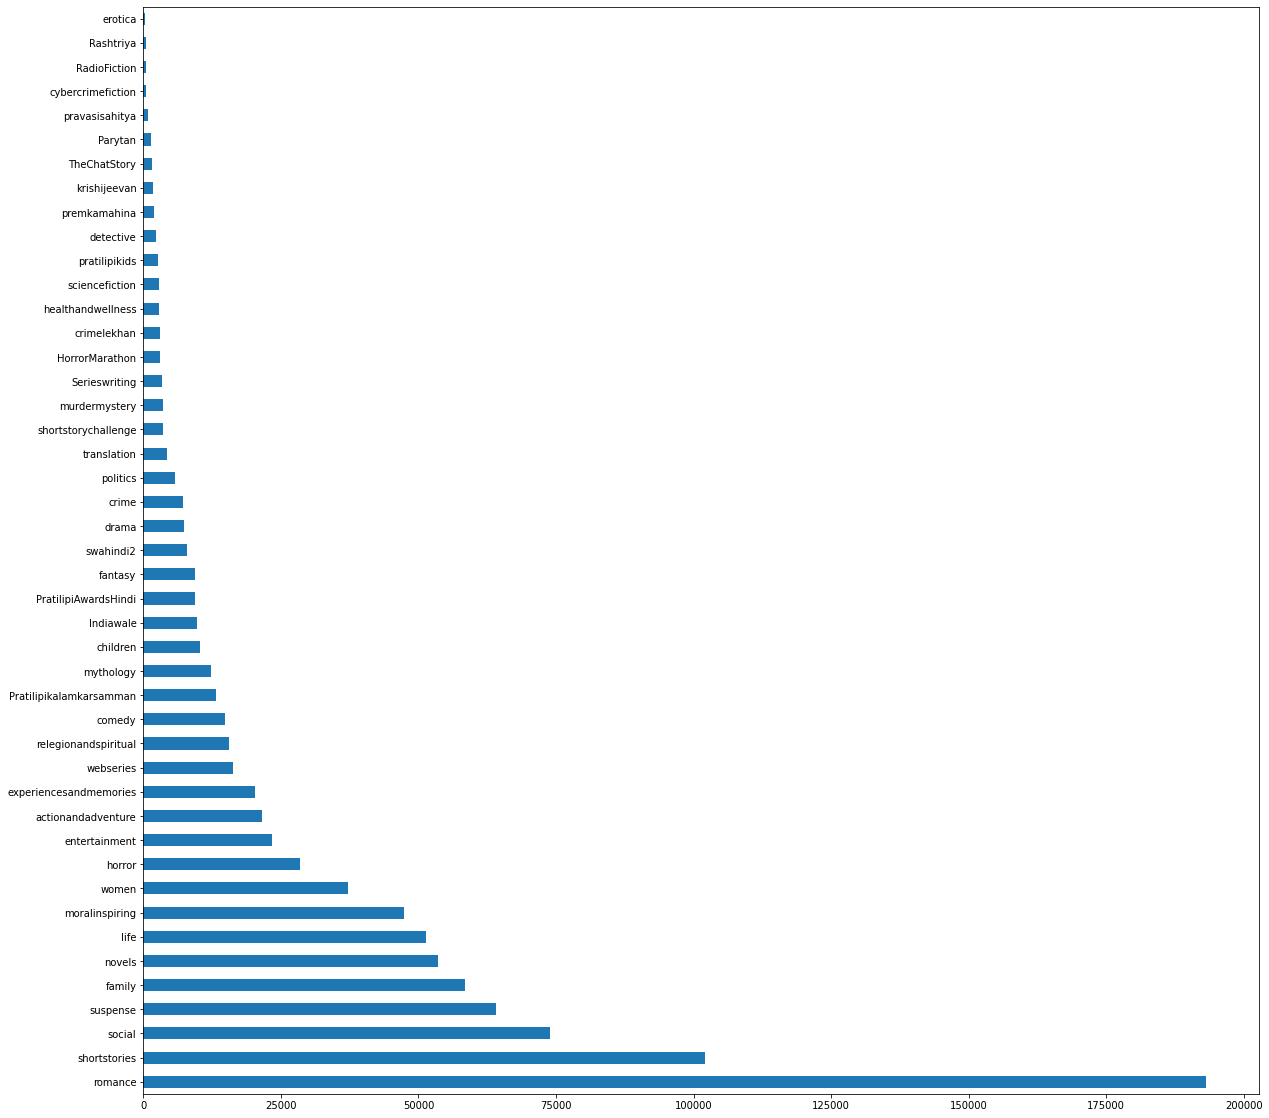

In [105]:
print(metadata["category_name"].value_counts().plot(kind='barh'))

## Check if one pratilipi can have multiple topics or not ?!

In [106]:
# Considering only one author is writing one story.
dupdata = metadata[metadata.duplicated(['pratilipi_id'])]
print("Duplicate Rows based on a pratilipi ids:", len(dupdata))

Duplicate Rows based on a pratilipi ids: 467808


So we know that if we group by pratilipi_id one story can have multiple category to them.

## Check if one pratilipi can have multiple authors or not ?!

In [107]:
# Considering only one author is writing one story.
dupdata = metadata[metadata.duplicated(['pratilipi_id',"author_id"])]
print("Duplicate Rows based on a pratilipi ids:", len(dupdata))

Duplicate Rows based on a pratilipi ids: 467808


So we know that if we group by pratilipi_id,author_id still number of duplication is same suggesting that one story cannot have multiple author to them.


## Check distribution of reading time across data

In [108]:
metadata.head()

,author_id,pratilipi_id,category_name,reading_time,updated_at,published_at
0,-3418949279741297,1025741862639304,translation,0,2020-08-19 15:26:13,2016-09-30 10:37:04
1,-2270332351871840,1377786215601277,translation,171,2021-01-21 16:27:07,2018-06-11 13:17:48
2,-2270332352037261,1377786215601962,translation,92,2020-09-29 12:33:57,2018-06-12 04:19:12
3,-2270332352521845,1377786215640994,translation,0,2019-10-17 09:03:37,2019-09-26 14:58:53
4,-2270332349665658,1377786215931338,translation,47,2020-05-05 11:33:41,2018-11-25 12:28:23


In [109]:
lis = [8*x for x in range(200)]

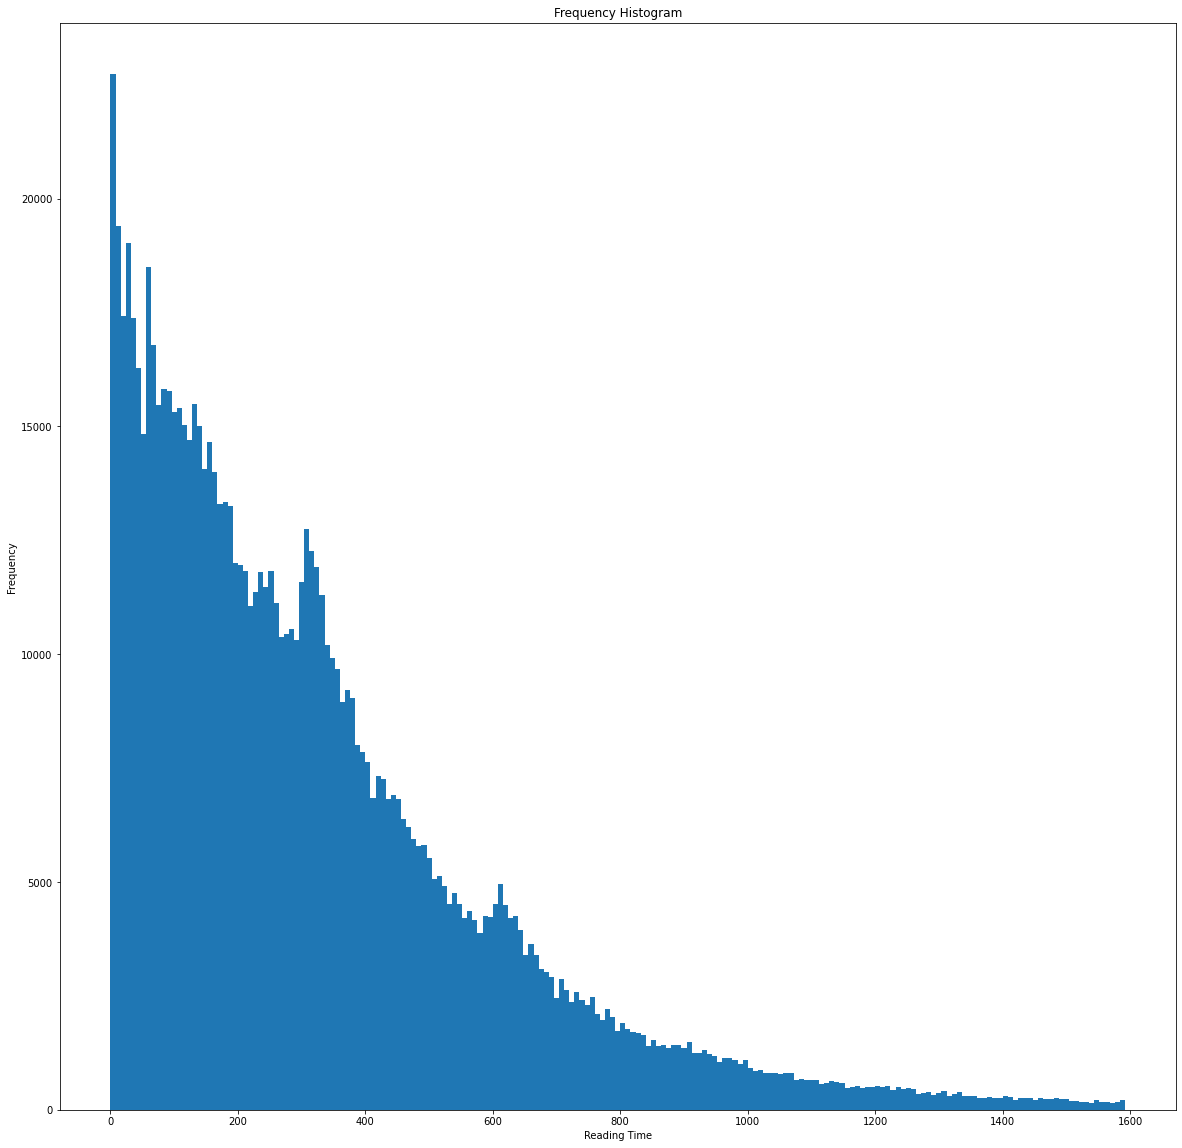

In [110]:
# distribution of reading time
x =metadata["reading_time"]
plt.hist(x, bins=lis)
plt.gca().set(title='Frequency Histogram', ylabel='Frequency',xlabel="Reading Time");

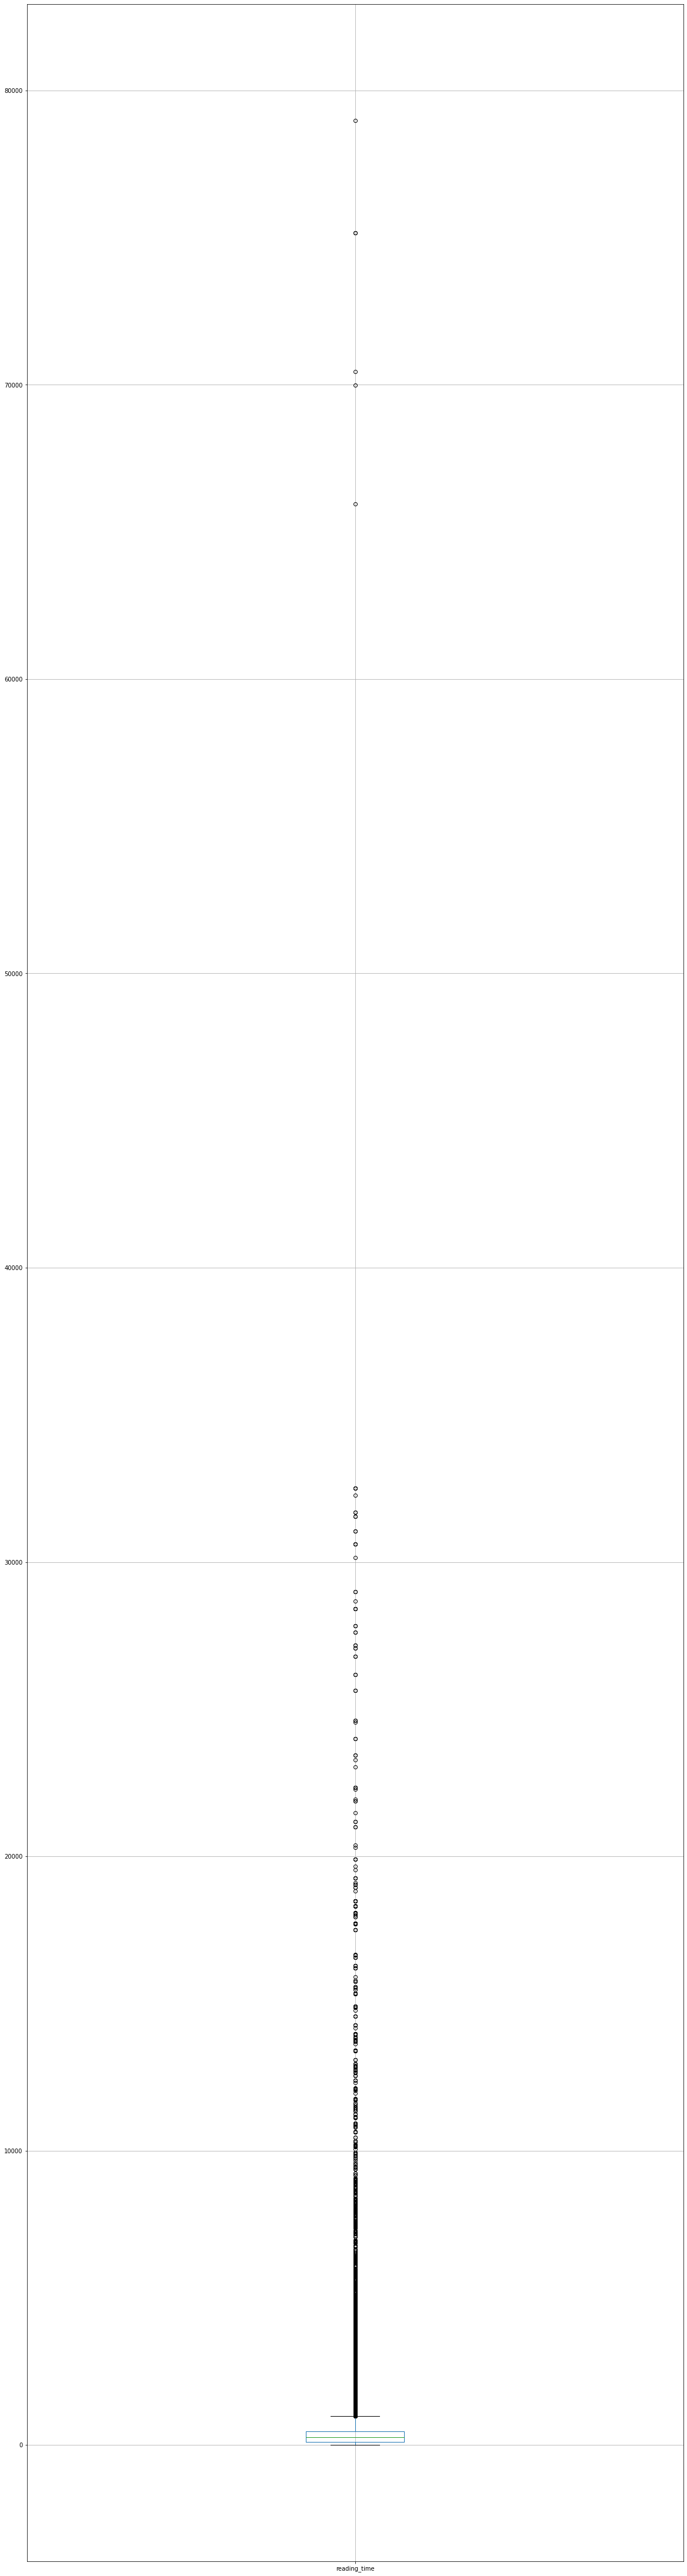

In [111]:
# undertading IQR range and outliers
metadata.boxplot(column=['reading_time'], return_type='axes',figsize=(20,80));

In [112]:
def inter_quantile_range(data, col):
    Q3 = np.quantile(data[col], 0.75)
    Q1 = np.quantile(data[col], 0.25)
    IQR = Q3 - Q1
 
    print("IQR value for column %s is: %s" % (col, IQR))
     
    lower_range = Q1 - 1.5 * IQR
    upper_range = Q3 + 1.5 * IQR
    if lower_range<0:
        lower_range = 0
    print("IQR range for column is: %s-%s" % (lower_range, upper_range))

In [113]:
inter_quantile_range(metadata, col="reading_time")

IQR value for column reading_time is: 350.0
IQR range for column is: 0-986.0


In [114]:
metadata["reading_time"].min(),metadata["reading_time"].max()

(0, 78983)

In [115]:
len(metadata[metadata["reading_time"]>986])

44710

In [116]:
len(metadata[metadata["reading_time"]<=0])

4055

* We can find that there are quite a few (about 44710) outliers in the dataset according to +- 1.5 * IQR range. Apart from this we find about about 4055 instance of 0 reading time

## Check distribution of reading percent across data

In [117]:
indata.head()

,user_id,pratilipi_id,read_percent,updated_at
0,5506791963854965,1377786220672965,100.0,2022-03-23 00:08:26.227
1,5506791979071996,1377786219742624,29.0,2022-03-23 00:08:26.220
2,5506791980256358,1377786217096334,22.0,2022-03-23 00:08:26.020
3,5506791988747277,1377786224767880,100.0,2022-03-23 00:08:25.306
4,5506791992372558,1377786218111595,100.0,2022-03-23 00:08:25.250


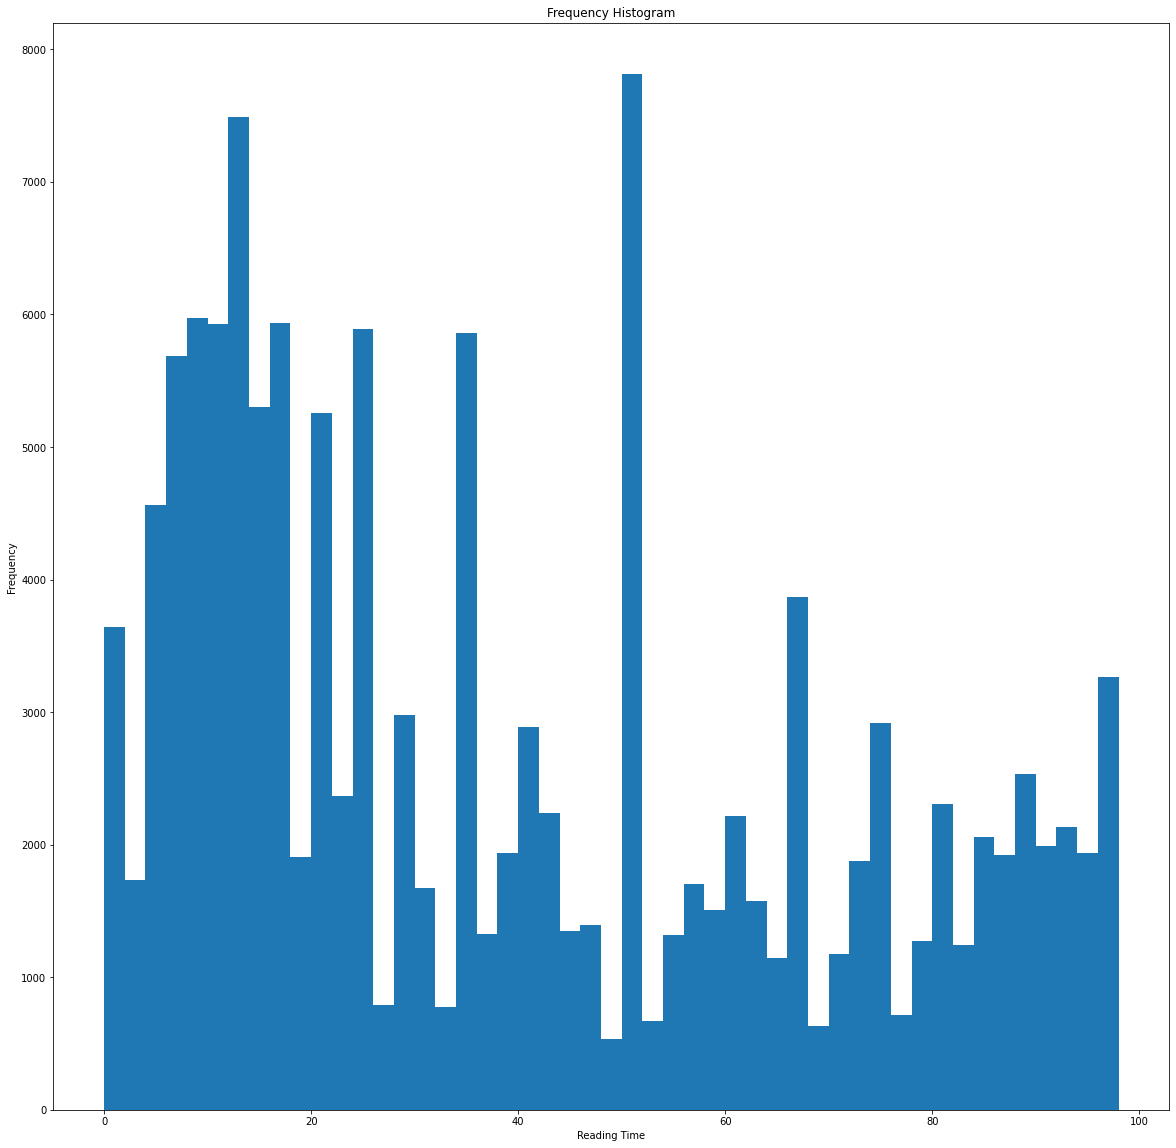

In [118]:
x =indata["read_percent"]
plt.hist(x, bins= [2*x for x in range(50)])
plt.gca().set(title='Frequency Histogram', ylabel='Frequency',xlabel="Reading Time");

In [119]:
len(indata[indata["read_percent"]>100])

14

##### So we have outliers in interaction dataset read percent with few greater than 100 which is most possibly annomaly!

In [120]:
len(indata[indata["read_percent"]==0])

3501

##### Many instances of read percent zero maybe due to technical glitch or closing session before starting the pratilipi

## Distribution of date across updated at in interaction data and published at in metadata

In [121]:
indata.columns

Index(['user_id', 'pratilipi_id', 'read_percent', 'updated_at'], dtype='object')

In [122]:
indata['updated_at'].max(),indata['updated_at'].min()

('2022-03-23 00:08:26.227', '2022-03-22 14:35:22.683')

In [123]:
indata['updated_at'].dtype

dtype('O')

In [124]:
indata['updated_at'] = indata['updated_at'].astype("datetime64")

In [125]:
indata['updated_at'].dtype

dtype('<M8[ns]')

<AxesSubplot:xlabel='updated_at'>

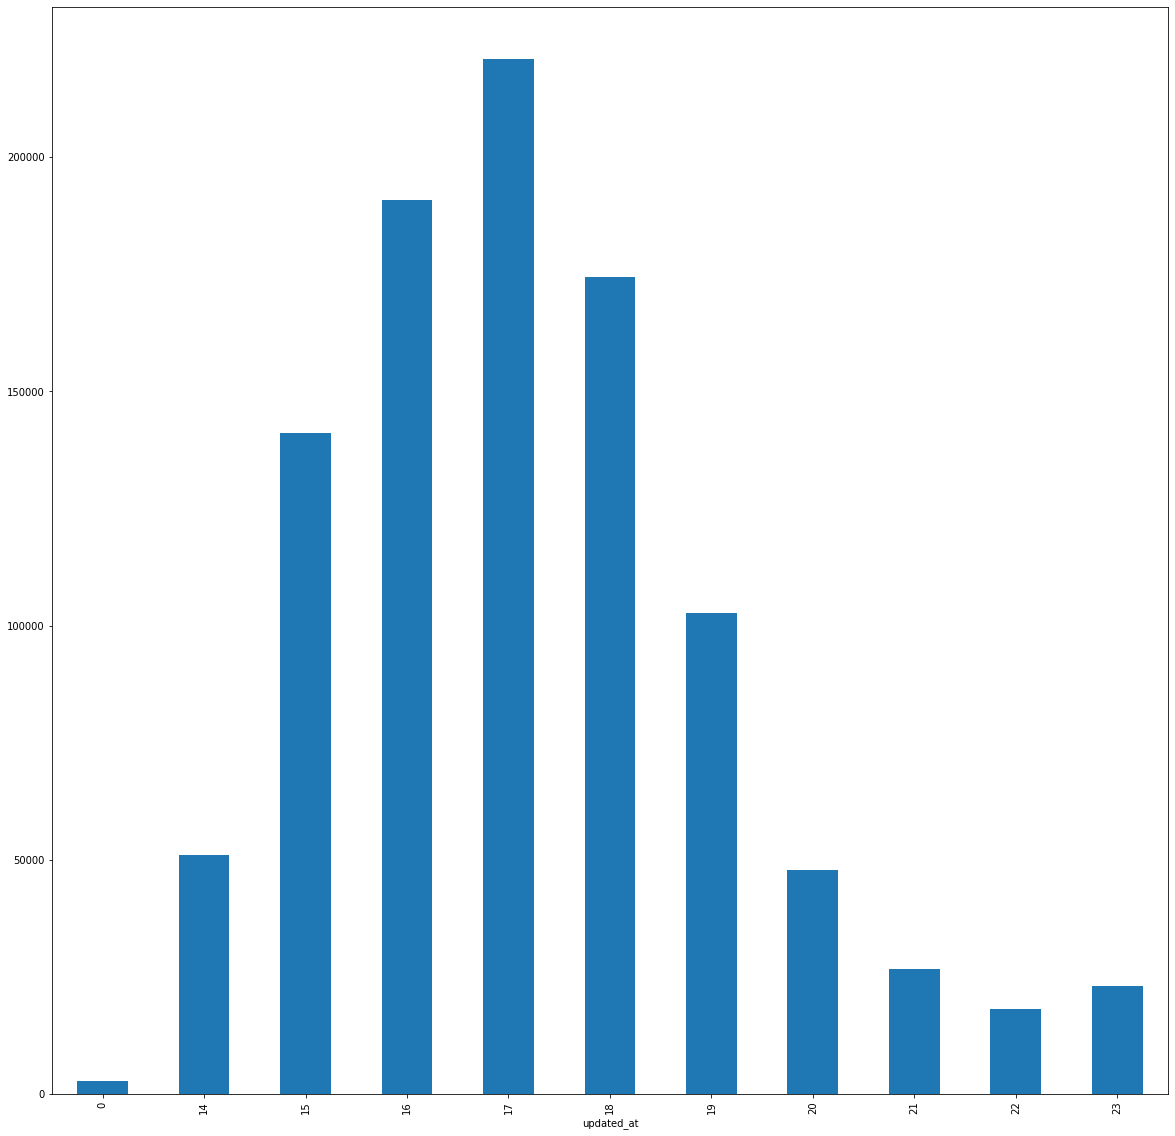

In [126]:
indata["updated_at"].groupby(indata["updated_at"].dt.hour).count().plot(kind="bar")

The peak time for the pratilipi users is around 3pm to 7pm everyday.

In [127]:
metadata.head()

,author_id,pratilipi_id,category_name,reading_time,updated_at,published_at
0,-3418949279741297,1025741862639304,translation,0,2020-08-19 15:26:13,2016-09-30 10:37:04
1,-2270332351871840,1377786215601277,translation,171,2021-01-21 16:27:07,2018-06-11 13:17:48
2,-2270332352037261,1377786215601962,translation,92,2020-09-29 12:33:57,2018-06-12 04:19:12
3,-2270332352521845,1377786215640994,translation,0,2019-10-17 09:03:37,2019-09-26 14:58:53
4,-2270332349665658,1377786215931338,translation,47,2020-05-05 11:33:41,2018-11-25 12:28:23


In [128]:
metadata["published_at"] = metadata["published_at"].astype("datetime64")

<AxesSubplot:xlabel='published_at'>

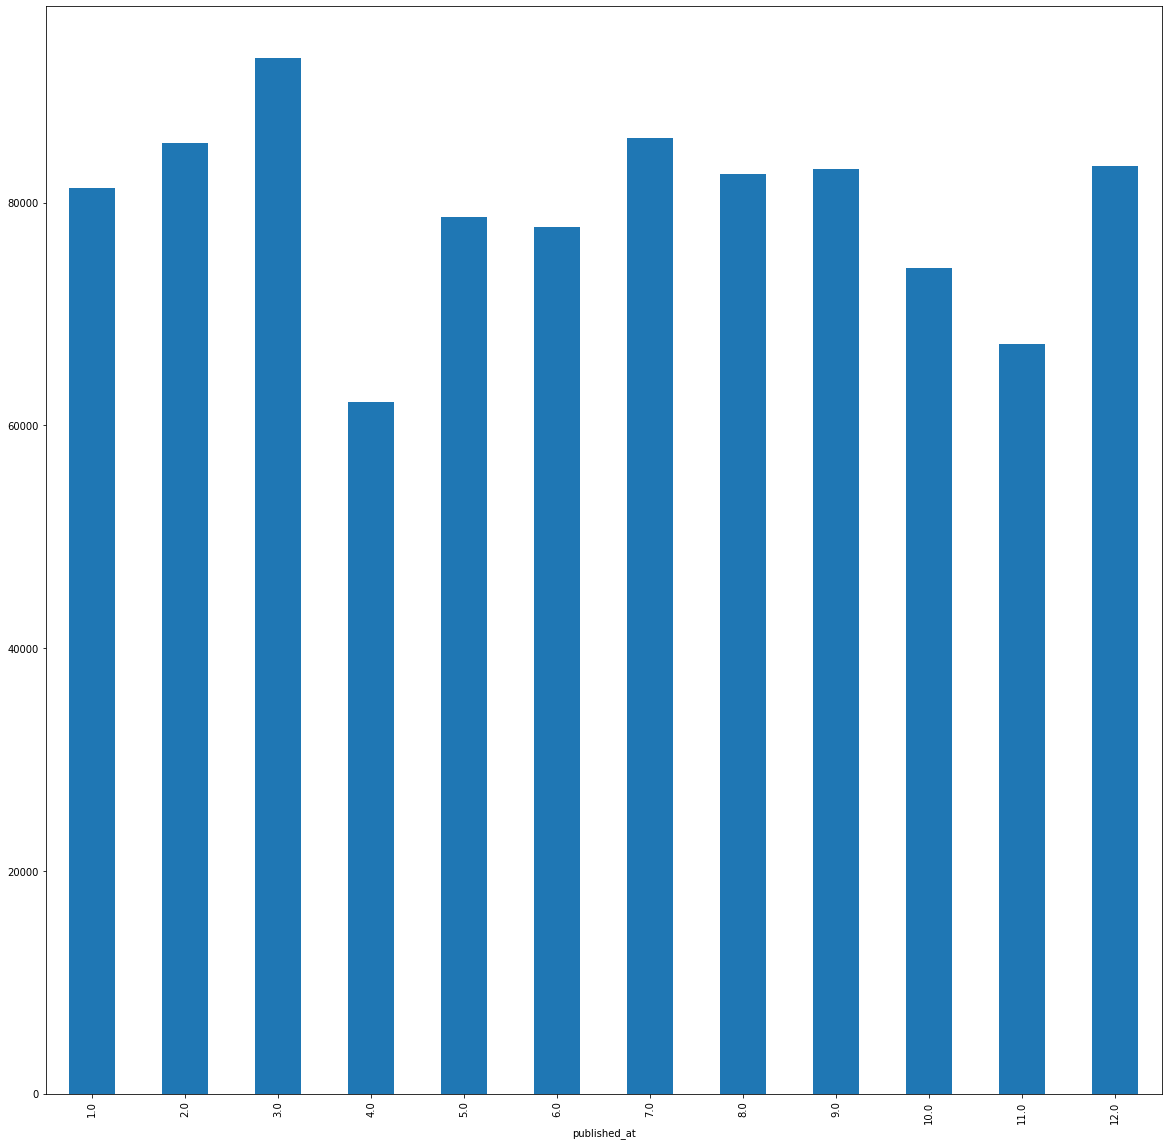

In [129]:
metadata["published_at"].groupby(metadata["published_at"].dt.month).count().plot(kind="bar")

### Publishing all around the year suggesting continous author engagement.

<AxesSubplot:xlabel='published_at'>

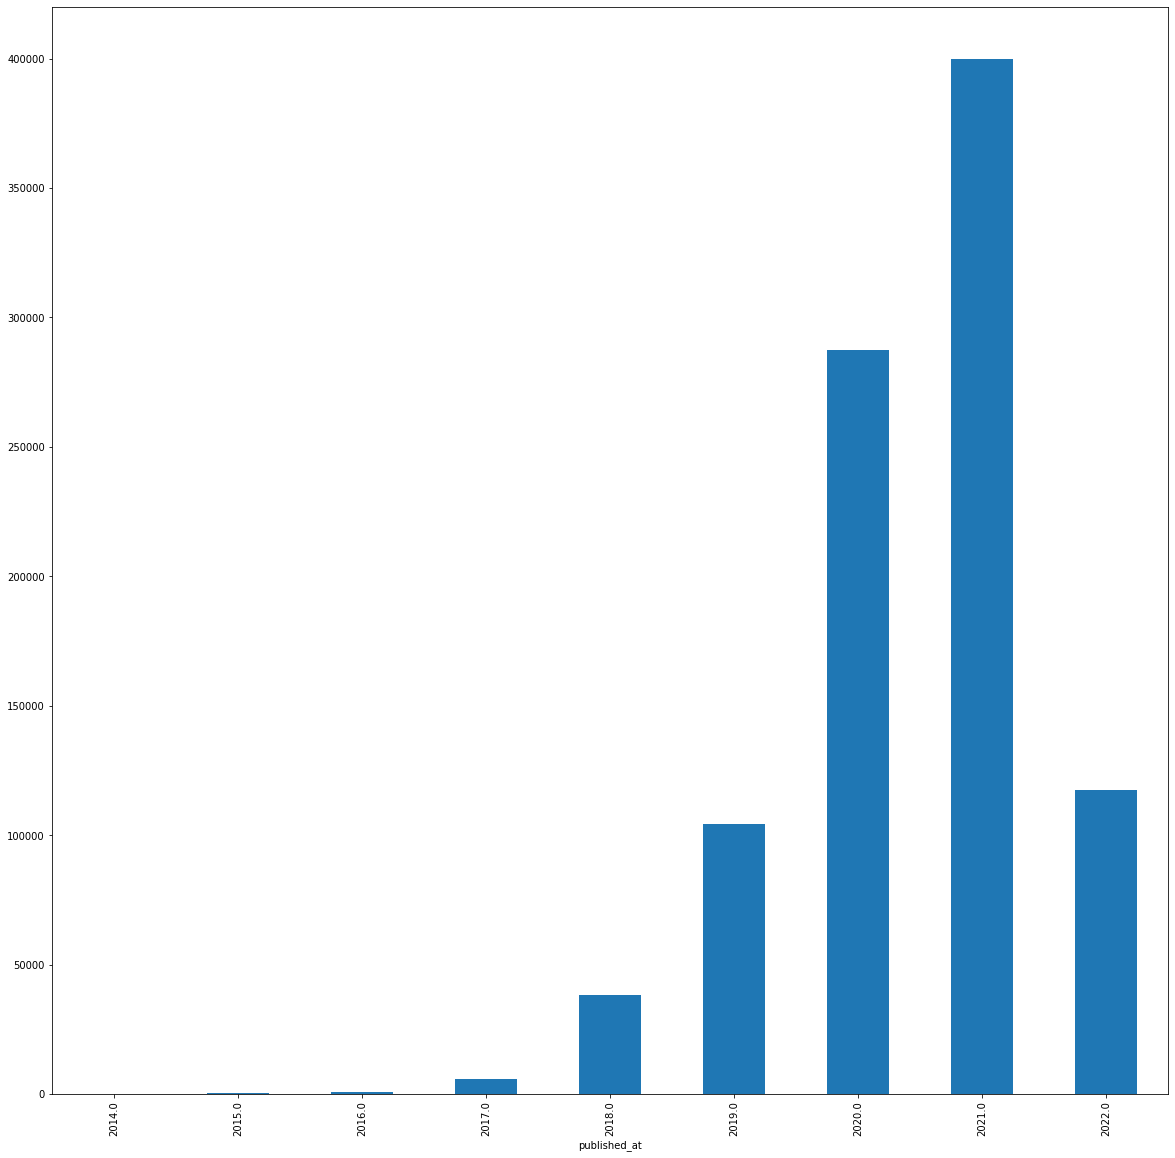

In [130]:
metadata["published_at"].groupby(metadata["published_at"].dt.year).count().plot(kind="bar")

##### Engagment is increasing over the years

<AxesSubplot:xlabel='published_at'>

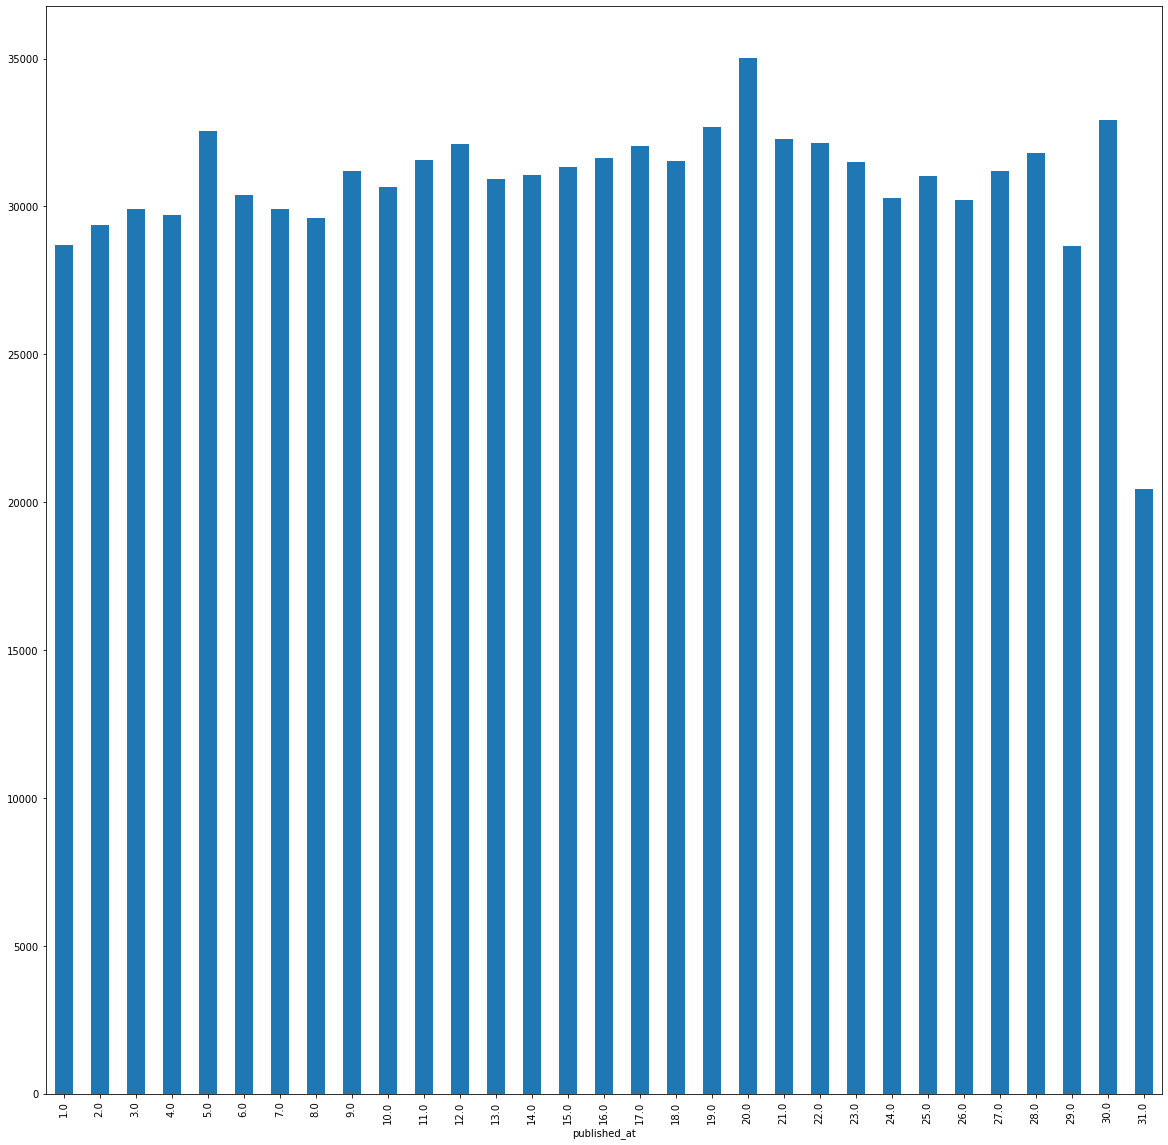

In [131]:
metadata["published_at"].groupby(metadata["published_at"].dt.day).count().plot(kind="bar")

## EDA summary

In [132]:
indata.head()

,user_id,pratilipi_id,read_percent,updated_at
0,5506791963854965,1377786220672965,100.0,2022-03-23 00:08:26.227
1,5506791979071996,1377786219742624,29.0,2022-03-23 00:08:26.220
2,5506791980256358,1377786217096334,22.0,2022-03-23 00:08:26.020
3,5506791988747277,1377786224767880,100.0,2022-03-23 00:08:25.306
4,5506791992372558,1377786218111595,100.0,2022-03-23 00:08:25.250


In [133]:
metadata.head()

,author_id,pratilipi_id,category_name,reading_time,updated_at,published_at
0,-3418949279741297,1025741862639304,translation,0,2020-08-19 15:26:13,2016-09-30 10:37:04
1,-2270332351871840,1377786215601277,translation,171,2021-01-21 16:27:07,2018-06-11 13:17:48
2,-2270332352037261,1377786215601962,translation,92,2020-09-29 12:33:57,2018-06-12 04:19:12
3,-2270332352521845,1377786215640994,translation,0,2019-10-17 09:03:37,2019-09-26 14:58:53
4,-2270332349665658,1377786215931338,translation,47,2020-05-05 11:33:41,2018-11-25 12:28:23


So far we have discovered few point to deep dive in the dataset and clean the dataset
* In metadata we have several instance of 0 second reading time which is quite wierd and caused maybe be due to some glich in collecting dataset or in somecases empty stories possibly(guess).
* Also in metadata we can also find instances of pratilipi with more than 10000 second(more than 2.5 hours ) reading time suggesting very large stories
* One partilipi can have multiple category but always a single author.
* In interaction data we found few instances of greater than 100 read_percent which is quite possibly some technical glitch cause it has only 14 such instances. ( if there were much more such instances have been possiblity of re-reading multiple time. )
* In interaction data we also found multiple 0 percent reading time which might be either user stopping the session before it start or some app related bug.
* Engagement around the month is similar and continously increasing across the year

## Cleaning Dataset and Treating Outliers and Feature engineering

* I won't be removing outlier anywhere except for reading percent in the assigment due to lack of knowledge of the actual reason

* Since there can be multiple topics for single pratilipi I will group them up in single list rather than using them individually

In [134]:
# converting innstance > 100 read_percent to =100 percent

In [135]:
## Any entry having greater than 100 percent read is converted back to 100 percent
indata['read_percent'] = indata['read_percent'].apply(lambda x: x if x<=100 else 100)

In [136]:
len(indata[indata["read_percent"]>100])
# no value with mor e than 100 percent

0

#### We will also remove interaction of those users having less than 20 interaction. 
* Intution is as per assigment we want about 5 prediction per user with 75-25 train test split so data is kept at 20. Also this problem is known as **cold start problem** in recommendation system in which it is hard do provide personalized recommendations for users with none or a very few number of consumed items, due to the lack of information to model their preferences.

* For this reason, we are keeping in the dataset only users with at least 20 interactions.

In [137]:
countdf = indata.groupby('user_id').count()

In [138]:
countdf.head()

,pratilipi_id,read_percent,updated_at
user_id,,,
3259192702313124,2,2,2
3260275089121956,49,49,49
3263710062617252,6,6,6
3263998672675492,59,59,59
3264239159386788,2,2,2


In [139]:
indata = indata.loc[indata['user_id'].isin(countdf[countdf['pratilipi_id'] > 20].index)].reset_index(drop = True)

In [140]:
# many user_id with less than 20 interaction dropped out
indata.shape

(471051, 4)

In [141]:
metadata.head()

,author_id,pratilipi_id,category_name,reading_time,updated_at,published_at
0,-3418949279741297,1025741862639304,translation,0,2020-08-19 15:26:13,2016-09-30 10:37:04
1,-2270332351871840,1377786215601277,translation,171,2021-01-21 16:27:07,2018-06-11 13:17:48
2,-2270332352037261,1377786215601962,translation,92,2020-09-29 12:33:57,2018-06-12 04:19:12
3,-2270332352521845,1377786215640994,translation,0,2019-10-17 09:03:37,2019-09-26 14:58:53
4,-2270332349665658,1377786215931338,translation,47,2020-05-05 11:33:41,2018-11-25 12:28:23


In [142]:
metadata.columns

Index(['author_id', 'pratilipi_id', 'category_name', 'reading_time',
       'updated_at', 'published_at'],
      dtype='object')

In [143]:
# Number of duplicates left after droping in pratilipi are 486693
len(metadata.drop_duplicates(subset = ["pratilipi_id"]))

486693

In [144]:
g = {'category_name':lambda x: list(x), 
     'updated_at':'max',
     'published_at' : 'min',
     "reading_time" : "mean"
    }

meta = metadata.groupby(['author_id', 'pratilipi_id']).agg(g).reset_index()

In [145]:
meta.head()

,author_id,pratilipi_id,category_name,updated_at,published_at,reading_time
0,-9070332352853360,312572401325768,"[novels, politics, social]",2018-12-03 01:57:32,2017-12-04 18:08:16,0.0
1,-9070332352853358,-96530313603384,[horror],2018-08-17 10:28:18,2017-12-04 19:11:01,0.0
2,-4566636240762225,1377786218853788,"[novels, romance, suspense]",2022-01-17 18:04:49,2020-04-27 09:31:23,81.0
3,-4566636240762225,1377786218889274,"[novels, romance, suspense]",2020-05-05 18:02:26,2020-05-05 18:02:26,112.0
4,-4566636240762225,1377786224904125,"[detective, romance, murdermystery]",2021-07-28 15:23:45,2021-07-28 14:14:45,262.0


In [146]:
meta.shape

(486693, 6)

In [147]:
# Changed ids to positive ( As i don't find any positive conterpart so it won't lead to duplicate issue)
meta["pratilipi_id"] = meta.apply(lambda x : abs(x["pratilipi_id"]),axis = 1)

In [148]:
meta["author_id"] = meta.apply(lambda x : abs(x["author_id"]),axis = 1)

In [149]:
# Converting ids have no effect on dataset
len(meta.drop_duplicates(subset=["author_id","pratilipi_id"]))

486693

In [150]:
meta.head()

,author_id,pratilipi_id,category_name,updated_at,published_at,reading_time
0,9070332352853360,312572401325768,"[novels, politics, social]",2018-12-03 01:57:32,2017-12-04 18:08:16,0.0
1,9070332352853358,96530313603384,[horror],2018-08-17 10:28:18,2017-12-04 19:11:01,0.0
2,4566636240762225,1377786218853788,"[novels, romance, suspense]",2022-01-17 18:04:49,2020-04-27 09:31:23,81.0
3,4566636240762225,1377786218889274,"[novels, romance, suspense]",2020-05-05 18:02:26,2020-05-05 18:02:26,112.0
4,4566636240762225,1377786224904125,"[detective, romance, murdermystery]",2021-07-28 15:23:45,2021-07-28 14:14:45,262.0


In [151]:
meta["month"] = meta["published_at"].dt.month

In [152]:
meta["year"] = meta["published_at"].dt.year

In [153]:
meta.head()

,author_id,pratilipi_id,category_name,updated_at,published_at,reading_time,month,year
0,9070332352853360,312572401325768,"[novels, politics, social]",2018-12-03 01:57:32,2017-12-04 18:08:16,0.0,12.0,2017.0
1,9070332352853358,96530313603384,[horror],2018-08-17 10:28:18,2017-12-04 19:11:01,0.0,12.0,2017.0
2,4566636240762225,1377786218853788,"[novels, romance, suspense]",2022-01-17 18:04:49,2020-04-27 09:31:23,81.0,4.0,2020.0
3,4566636240762225,1377786218889274,"[novels, romance, suspense]",2020-05-05 18:02:26,2020-05-05 18:02:26,112.0,5.0,2020.0
4,4566636240762225,1377786224904125,"[detective, romance, murdermystery]",2021-07-28 15:23:45,2021-07-28 14:14:45,262.0,7.0,2021.0


In [154]:
#helps decrease the speard and make data bit more uniform
meta['reading_time_min'] = meta['reading_time'].apply(lambda x: int(x/60))

In [155]:
meta.head()

,author_id,pratilipi_id,category_name,updated_at,published_at,reading_time,month,year,reading_time_min
0,9070332352853360,312572401325768,"[novels, politics, social]",2018-12-03 01:57:32,2017-12-04 18:08:16,0.0,12.0,2017.0,0
1,9070332352853358,96530313603384,[horror],2018-08-17 10:28:18,2017-12-04 19:11:01,0.0,12.0,2017.0,0
2,4566636240762225,1377786218853788,"[novels, romance, suspense]",2022-01-17 18:04:49,2020-04-27 09:31:23,81.0,4.0,2020.0,1
3,4566636240762225,1377786218889274,"[novels, romance, suspense]",2020-05-05 18:02:26,2020-05-05 18:02:26,112.0,5.0,2020.0,1
4,4566636240762225,1377786224904125,"[detective, romance, murdermystery]",2021-07-28 15:23:45,2021-07-28 14:14:45,262.0,7.0,2021.0,4


In [156]:
indata.head()

,user_id,pratilipi_id,read_percent,updated_at
0,5506791992372558,1377786218111595,100.0,2022-03-23 00:08:25.250
1,5506791948826385,1377786225616273,100.0,2022-03-23 00:08:23.302
2,5506791996685034,1377786220761266,100.0,2022-03-23 00:08:22.974
3,5506791959279525,1377786225901639,100.0,2022-03-23 00:08:16.603
4,5506791982720411,1377786218206736,2.0,2022-03-23 00:08:15.385


In [157]:
# Remove all stories published after the minimum intereaction datetime so that recommendation is evaluated fairly
indata["updated_at"].min()

Timestamp('2022-03-22 14:35:22.685000')

In [158]:
meta.shape

(486693, 9)

In [159]:
meta = meta[meta["published_at"]<indata["updated_at"].min()].reset_index(drop = True)

In [160]:
meta.shape

(485531, 9)

In [161]:
indata.shape

(471051, 4)

In [162]:
indata = indata[indata["pratilipi_id"].isin(meta["pratilipi_id"].unique())].reset_index(drop = True)

In [163]:
# Remove interactions with record of their metadata 
indata.shape

(273990, 4)

In [164]:
meta.head()

,author_id,pratilipi_id,category_name,updated_at,published_at,reading_time,month,year,reading_time_min
0,9070332352853360,312572401325768,"[novels, politics, social]",2018-12-03 01:57:32,2017-12-04 18:08:16,0.0,12.0,2017.0,0
1,9070332352853358,96530313603384,[horror],2018-08-17 10:28:18,2017-12-04 19:11:01,0.0,12.0,2017.0,0
2,4566636240762225,1377786218853788,"[novels, romance, suspense]",2022-01-17 18:04:49,2020-04-27 09:31:23,81.0,4.0,2020.0,1
3,4566636240762225,1377786218889274,"[novels, romance, suspense]",2020-05-05 18:02:26,2020-05-05 18:02:26,112.0,5.0,2020.0,1
4,4566636240762225,1377786224904125,"[detective, romance, murdermystery]",2021-07-28 15:23:45,2021-07-28 14:14:45,262.0,7.0,2021.0,4


In [165]:
# we will remove updated_at and published_at(features already captured)
meta.drop(["updated_at","published_at","author_id","reading_time"],axis = 1,inplace = True)

In [166]:
meta.head()

,pratilipi_id,category_name,month,year,reading_time_min
0,312572401325768,"[novels, politics, social]",12.0,2017.0,0
1,96530313603384,[horror],12.0,2017.0,0
2,1377786218853788,"[novels, romance, suspense]",4.0,2020.0,1
3,1377786218889274,"[novels, romance, suspense]",5.0,2020.0,1
4,1377786224904125,"[detective, romance, murdermystery]",7.0,2021.0,4


In [167]:
meta.columns

Index(['pratilipi_id', 'category_name', 'month', 'year', 'reading_time_min'], dtype='object')

In [168]:
indata.head()

,user_id,pratilipi_id,read_percent,updated_at
0,5506791992372558,1377786218111595,100.0,2022-03-23 00:08:25.250
1,5506791959279525,1377786225901639,100.0,2022-03-23 00:08:16.603
2,5506791973513254,1377786227564949,90.0,2022-03-23 00:08:14.542
3,5506791954805098,1377786220151688,100.0,2022-03-23 00:08:10.493
4,5506791976871041,1377786225173250,15.0,2022-03-23 00:08:04.897


In [169]:
df = indata.merge(meta, on = 'pratilipi_id',how = 'left')
df.head()

,user_id,pratilipi_id,read_percent,updated_at,category_name,month,year,reading_time_min
0,5506791992372558,1377786218111595,100.0,2022-03-23 00:08:25.250,"[novels, romance, suspense]",2.0,2020.0,29
1,5506791959279525,1377786225901639,100.0,2022-03-23 00:08:16.603,"[romance, suspense, horror]",10.0,2021.0,10
2,5506791973513254,1377786227564949,90.0,2022-03-23 00:08:14.542,"[actionandadventure, romance]",2.0,2022.0,8
3,5506791954805098,1377786220151688,100.0,2022-03-23 00:08:10.493,"[family, romance, entertainment]",7.0,2020.0,5
4,5506791976871041,1377786225173250,15.0,2022-03-23 00:08:04.897,"[novels, family, romance]",8.0,2021.0,12


In [170]:
#function to build entire feature set and merging both dataset
def create_feature_set(meta,indata):
    """ 
    Process df to create a final set of features that will be used to generate recommendations

    Parameters: 
        df (pandas dataframe): Dataframe
        float_cols (list(str)): List of float columns that will be scaled 
        
    Returns: 
        final: final set of features 
    """
    df = indata.merge(meta, on = 'pratilipi_id',how = 'left')
    tfidf = TfidfVectorizer()
    tfidf_matrix =  tfidf.fit_transform(df['category_name'].apply(lambda x: ",".join(x)))
    genre_df = pd.DataFrame(tfidf_matrix.toarray())
    genre_df.columns = ['genre' + "|" + i for i in tfidf.get_feature_names()]
    genre_df.reset_index(drop = True, inplace=True)
    #concanenate all features
    final = pd.concat([df,genre_df], axis = 1)
    final.drop(["category_name"],axis =1,inplace = True)
    print(genre_df.columns)
    return final

In [171]:
final = create_feature_set(meta,indata)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Index(['genre|actionandadventure', 'genre|children', 'genre|comedy',
       'genre|crime', 'genre|crimelekhan', 'genre|cybercrimefiction',
       'genre|detective', 'genre|drama', 'genre|entertainment',
       'genre|erotica', 'genre|experiencesandmemories', 'genre|family',
       'genre|fantasy', 'genre|healthandwellness', 'genre|horror',
       'genre|horrormarathon', 'genre|indiawale', 'genre|krishijeevan',
       'genre|life', 'genre|moralinspiring', 'genre|murdermystery',
       'genre|mythology', 'genre|novels', 'genre|parytan', 'genre|politics',
       'genre|pratilipiawardshindi', 'genre|pratilipikalamkarsamman',
       'genre|pratilipikids', 'genre|pravasisahitya', 'genre|premkamahina',
       'genre|radiofiction', 'genre|rashtriya', 'genre|relegionandspiritual',
       'genre|romance', 'genre|sciencefiction', 'genre|serieswriting',
       'genre|shortstories', 'genre|shortstorychallenge', 'genre|social',
       'genre|suspense', 'genre|swahindi2', 'genre|thechatstory',
      

In [172]:
final.head()

,user_id,pratilipi_id,read_percent,updated_at,month,year,reading_time_min,genre|actionandadventure,genre|children,genre|comedy,...,genre|serieswriting,genre|shortstories,genre|shortstorychallenge,genre|social,genre|suspense,genre|swahindi2,genre|thechatstory,genre|translation,genre|webseries,genre|women
0,5506791992372558,1377786218111595,100.0,2022-03-23 00:08:25.250,2.0,2020.0,29,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.681687,0.0,0.0,0.0,0.0,0.0
1,5506791959279525,1377786225901639,100.0,2022-03-23 00:08:16.603,10.0,2021.0,10,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.471827,0.0,0.0,0.0,0.0,0.0
2,5506791973513254,1377786227564949,90.0,2022-03-23 00:08:14.542,2.0,2022.0,8,0.922757,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,5506791954805098,1377786220151688,100.0,2022-03-23 00:08:10.493,7.0,2020.0,5,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,5506791976871041,1377786225173250,15.0,2022-03-23 00:08:04.897,8.0,2021.0,12,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [173]:
final.shape

(273990, 52)

### Splitting the whole dataset per user into 75-25 for train test split according to timestamp so that prediction are not done using future data

In [174]:
ranks = final.groupby('user_id')['updated_at'].rank(method='first')

In [175]:
ranks

0         27.0
1         30.0
2         67.0
3         17.0
4         25.0
          ... 
273985     2.0
273986     1.0
273987     1.0
273988     1.0
273989     1.0
Name: updated_at, Length: 273990, dtype: float64

In [176]:
counts = final['user_id'].map(df.groupby('user_id')['updated_at'].apply(len))

In [177]:
final["train"]=(ranks / counts) <= 0.75

In [178]:
final["train"].value_counts()

True     200799
False     73191
Name: train, dtype: int64

In [179]:
train,test = final[final["train"]==True].reset_index(drop = True),final[final["train"]==False].reset_index(drop = True)

In [180]:
len(train["user_id"].unique()),len(test["user_id"].unique())

(12085, 12263)

In [181]:
train.shape,test.shape

((200799, 53), (73191, 53))

In [182]:
test.head()

,user_id,pratilipi_id,read_percent,updated_at,month,year,reading_time_min,genre|actionandadventure,genre|children,genre|comedy,...,genre|shortstories,genre|shortstorychallenge,genre|social,genre|suspense,genre|swahindi2,genre|thechatstory,genre|translation,genre|webseries,genre|women,train
0,5506791992372558,1377786218111595,100.0,2022-03-23 00:08:25.250,2.0,2020.0,29,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.681687,0.0,0.0,0.0,0.0,0.0,False
1,5506791959279525,1377786225901639,100.0,2022-03-23 00:08:16.603,10.0,2021.0,10,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.471827,0.0,0.0,0.0,0.0,0.0,False
2,5506791973513254,1377786227564949,90.0,2022-03-23 00:08:14.542,2.0,2022.0,8,0.922757,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,False
3,5506791954805098,1377786220151688,100.0,2022-03-23 00:08:10.493,7.0,2020.0,5,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,False
4,5506791976871041,1377786225173250,15.0,2022-03-23 00:08:04.897,8.0,2021.0,12,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,False


In [183]:
test = test[test["user_id"].isin(train["user_id"].unique())]
test = test[test["pratilipi_id"].isin(train["pratilipi_id"].unique())]

In [184]:
test.shape

(61435, 53)

In [185]:
train.to_csv("train.csv",index = False)
test.to_csv("test.csv",index = False)